In [ ]:
# ============================================================
# Setup and Directory Management
# ============================================================
import os
import sys
from pathlib import Path

# Check current directory
print(f"Current directory: {os.getcwd()}")

# If we're in the notebook directory, move to project root
if 'notebook' in os.getcwd():
    os.chdir('../')
    print(f"Changed to: {os.getcwd()}")

Current directory: c:\09_AHFID\CervicalAI-Screen\notebook
Changed to: c:\09_AHFID\CervicalAI-Screen


In [ ]:
# ============================================================
# Import Required Libraries
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import numpy as np
import json
import random
from pathlib import Path
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import time
import timm
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Libraries imported successfully")

c:\09_AHFID\CervicalAI-Screen\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully


In [ ]:
# ============================================================
# Define Model Architecture
# ============================================================
class SSLEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.3):
        super(SSLEfficientNet, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Linear(128, 64))
        self.classifier = nn.Sequential(nn.Dropout(dropout_rate), nn.Linear(self.feature_dim, 256), nn.ReLU(inplace=True), nn.Dropout(dropout_rate * 0.5), nn.Linear(256, num_classes))
        self._initialize_weights()
    def _initialize_weights(self):
        for m in [self.projector, self.classifier]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
    def forward(self, x): return self.classifier(self.backbone(x))

def create_model(num_classes=2, model_name='efficientnet_b0', dropout_rate=0.3):
    return SSLEfficientNet(model_name=model_name, num_classes=num_classes, dropout_rate=dropout_rate)

print("Model architecture defined")

Model architecture defined (compatible with existing checkpoint)


In [ ]:
# ============================================================
# Loss Function
# ============================================================
class WeightedFocalLoss(nn.Module):
    """Focal loss with alpha weighting to handle imbalance and prioritize positive class."""
    def __init__(self, alpha=0.9, gamma=2.0):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([1 - alpha, alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt)**self.gamma * BCE_loss
        return F_loss.mean()

print("Weighted Focal Loss function defined")

High-sensitivity loss functions defined


In [5]:
# ============================================================
# Dataset Classes for SSL
# ============================================================

class LabeledDataset(Dataset):
    """Dataset for standard labeled images."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply specific transforms for positive and negative classes
        if label == 1:
            image = positive_transform(image)
        else:
            image = negative_transform(image)
            
        return image, label

# NEW: Dataset for unlabeled images, providing two augmented views
class UnlabeledDataset(Dataset):
    """Dataset for unlabeled images, creating weakly and strongly augmented pairs."""
    def __init__(self, image_paths, weak_transform, strong_transform):
        self.image_paths = image_paths
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        weak_aug = self.weak_transform(image)
        strong_aug = self.strong_transform(image)
        
        return weak_aug, strong_aug

class ValidationDataset(Dataset):
    """Simple dataset for validation with a single transform."""
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        return image, label

print("Dataset classes defined for SSL")

Dataset classes defined for SSL


In [6]:
# ============================================================
# Data Transforms for SSL
# ============================================================

# Strong augmentation for positive labeled cases and strong view of unlabeled cases
strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Alias for clarity
positive_transform = strong_transform

# Moderate augmentation for negative labeled cases
negative_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# NEW: Weak augmentation for generating pseudo-labels from unlabeled data
weak_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms defined for SSL")

Data transforms defined for SSL


In [7]:
# ============================================================
# Data Loading for SSL
# ============================================================

def load_and_prepare_data():
    """Load labeled and unlabeled data"""
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir, unlabeled_dir = data_dir / "labeled", data_dir / "unlabeled"
    
    # Labeled data
    labeled_paths, labels = [], []
    class_to_idx = {"Negative": 0, "Positive": 1}
    for name, idx in class_to_idx.items():
        class_dir = labeled_dir / name
        if class_dir.exists():
            for path in class_dir.glob("*"):
                if path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    labeled_paths.append(str(path))
                    labels.append(idx)
    
    print(f"Loaded {len(labeled_paths)} labeled images")
    print(f"Class distribution: {Counter(labels)}")
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
    )
    
    # Unlabeled data
    unlabeled_paths = []
    if unlabeled_dir.exists():
        for path in unlabeled_dir.glob("*"):
            if path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                unlabeled_paths.append(str(path))
    
    print(f"Loaded {len(unlabeled_paths)} unlabeled images")
    
    # Create datasets
    train_dataset = LabeledDataset(train_paths, train_labels, transform=None) # Transforms applied in __getitem__
    val_dataset = ValidationDataset(val_paths, val_labels, val_transform)
    unlabeled_dataset = UnlabeledDataset(unlabeled_paths, weak_transform, strong_transform)

    print(f"\nDataset summary:")
    print(f"  Labeled training: {len(train_dataset)} images")
    print(f"  Validation: {len(val_dataset)} images")
    print(f"  Unlabeled: {len(unlabeled_dataset)} images")
    
    return train_dataset, val_dataset, unlabeled_dataset, train_labels

print("Data loading functions defined for SSL")


Data loading functions defined for SSL


In [8]:
# ============================================================
# Custom Training Loop for Optimal Balance for SSL
# ============================================================

class HighSensitivityTrainer:
    """Trainer optimized for clinically optimal balance between FN and FP."""
    
    def __init__(self, model, device='cuda', ssl_weight=1.0, confidence_thresh=0.95):
        self.model = model.to(device)
        self.device = device
        self.criterion = CombinedScreeningLoss()
        self.ssl_weight = ssl_weight
        self.confidence_thresh = confidence_thresh
        
        self.optimizer = torch.optim.AdamW([
            {'params': model.backbone.parameters(), 'lr': 1e-5},
            {'params': model.classifier.parameters(), 'lr': 5e-4},
            {'params': model.projector.parameters(), 'lr': 5e-4}
        ])
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=10, T_mult=2)
        
        self.history = {'train_loss': [], 'consistency_loss': [], 'val_loss': [], 'sensitivity': [], 
                        'specificity': [], 'false_negatives': [], 'false_positives': []}
        
        # MODIFIED: Trackers for the new saving logic
        self.best_fn_count = float('inf')
        self.best_fp_count_at_best_fn = float('inf')
        
    def train_epoch(self, labeled_loader, unlabeled_loader, epoch):
        """Train for one epoch using both labeled and unlabeled data."""
        self.model.train()
        total_sup_loss, total_cons_loss = 0, 0
        unlabeled_iter = iter(unlabeled_loader)
        
        pbar = tqdm(labeled_loader, desc=f'Epoch {epoch+1}')
        for batch_idx, (labeled_images, labels) in enumerate(pbar):
            labeled_images, labels = labeled_images.to(self.device), labels.to(self.device)
            logits_l = self.model(labeled_images)
            sup_loss = self.criterion(logits_l, labels)
            
            try:
                images_u_w, images_u_s = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                images_u_w, images_u_s = next(unlabeled_iter)

            images_u_w, images_u_s = images_u_w.to(self.device), images_u_s.to(self.device)
            
            with torch.no_grad():
                logits_u_w = self.model(images_u_w)
                probs_u_w = F.softmax(logits_u_w, dim=1)
                max_probs, p_targets = torch.max(probs_u_w, dim=1)
                mask = max_probs.ge(self.confidence_thresh).float()

            logits_u_s = self.model(images_u_s)
            cons_loss = (F.cross_entropy(logits_u_s, p_targets, reduction='none') * mask).mean()
            
            total_loss = sup_loss + self.ssl_weight * cons_loss
            
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_sup_loss += sup_loss.item()
            total_cons_loss += cons_loss.item()
            pbar.set_postfix({'sup_loss': f'{sup_loss.item():.4f}', 'cons_loss': f'{cons_loss.item():.4f}'})
        
        avg_sup_loss = total_sup_loss / len(labeled_loader)
        avg_cons_loss = total_cons_loss / len(labeled_loader)
        return avg_sup_loss, avg_cons_loss

    def validate(self, val_loader, threshold=0.5):
        self.model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                probs = F.softmax(logits, dim=1)
                preds = (probs[:, 1] > threshold).long()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_preds, all_labels = np.array(all_preds), np.array(all_labels)
        tp = np.sum((all_labels == 1) & (all_preds == 1))
        fn = np.sum((all_labels == 1) & (all_preds == 0))
        tn = np.sum((all_labels == 0) & (all_preds == 0))
        fp = np.sum((all_labels == 0) & (all_preds == 1))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        return {'sensitivity': sensitivity, 'specificity': specificity, 'false_negatives': fn, 'false_positives': fp}
    
    def find_optimal_threshold(self, val_loader, target_fn=1, target_fp=3):
        """Find the best threshold that meets the clinical targets."""
        self.model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images)
                all_probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        all_probs, all_labels = np.array(all_probs), np.array(all_labels)
        best_threshold = 0.5
        best_fp = float('inf')
        
        # Find a threshold that satisfies FN <= target_fn first
        candidate_thresholds = []
        for threshold in np.linspace(0.05, 0.95, 100):
            preds = (all_probs > threshold).astype(int)
            fn = np.sum((all_labels == 1) & (preds == 0))
            if fn <= target_fn:
                candidate_thresholds.append(threshold)
        
        # Among candidates, find the one that minimizes FP
        if not candidate_thresholds:
            print("  ! Could not find a threshold to meet target FN. Falling back to previous logic.")
            return self.find_fallback_threshold(all_probs, all_labels)

        for threshold in candidate_thresholds:
            preds = (all_probs > threshold).astype(int)
            fp = np.sum((all_labels == 0) & (preds == 1))
            if fp < best_fp:
                best_fp = fp
                best_threshold = threshold
        
        print(f"  Optimal threshold found: {best_threshold:.3f} (FP: {best_fp} at FN <= {target_fn})")
        return best_threshold

    def find_fallback_threshold(self, all_probs, all_labels):
        """Fallback logic if clinical targets cannot be met."""
        best_threshold, best_score, min_fn = 0.5, -float('inf'), float('inf')
        for threshold in np.linspace(0.05, 0.95, 100):
            preds = (all_probs > threshold).astype(int)
            tp = np.sum((all_labels == 1) & (preds == 1)); fn = np.sum((all_labels == 1) & (preds == 0))
            tn = np.sum((all_labels == 0) & (preds == 0)); fp = np.sum((all_labels == 0) & (preds == 1))
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            score = (sensitivity * 1.5) + (specificity * 2.5)
            if fn < min_fn or (fn == min_fn and score > best_score):
                best_threshold, best_score, min_fn = threshold, score, fn
        return best_threshold

    def train(self, labeled_loader, unlabeled_loader, val_loader, epochs=50):
        print("\n" + "="*60); print("STARTING SEMI-SUPERVISED TRAINING"); print("="*60)
        patience, max_patience = 0, 15
        
        for epoch in range(epochs):
            train_loss, cons_loss = self.train_epoch(labeled_loader, unlabeled_loader, epoch)
            optimal_threshold = self.find_optimal_threshold(val_loader, target_fn=1, target_fp=3)
            metrics = self.validate(val_loader, threshold=optimal_threshold)
            self.scheduler.step()
            
            self.history['train_loss'].append(train_loss)
            self.history['consistency_loss'].append(cons_loss)
            for key, value in metrics.items(): self.history[key].append(value)
            
            print(f"\nEpoch {epoch+1}/{epochs}")
            print(f"  Supervised Loss: {train_loss:.4f}, Consistency Loss: {cons_loss:.4f}")
            print(f"  Sensitivity: {metrics['sensitivity']:.3f}, Specificity: {metrics['specificity']:.3f}")
            print(f"  FALSE NEGATIVES: {metrics['false_negatives']}, False Positives: {metrics['false_positives']}")
            print(f"  Threshold Used: {optimal_threshold:.3f}")
            
            # MODIFIED: Stricter saving logic to meet clinical goals
            is_best = False
            if metrics['false_negatives'] < self.best_fn_count:
                is_best = True
            elif metrics['false_negatives'] == self.best_fn_count and metrics['false_positives'] < self.best_fp_count_at_best_fn:
                is_best = True

            if is_best:
                self.best_fn_count = metrics['false_negatives']
                self.best_fp_count_at_best_fn = metrics['false_positives']
                patience = 0
                checkpoint = {'epoch': epoch, 'model_state_dict': self.model.state_dict(),
                              'optimizer_state_dict': self.optimizer.state_dict(), 'metrics': metrics, 
                              'threshold': optimal_threshold, 'history': self.history}
                # MODIFIED: Filename changed to reflect balanced model
                torch.save(checkpoint, 'artifacts/balanced_sensitivity_model.pth')
                print(f"  ✓ Saved best model (FN: {metrics['false_negatives']}, FP: {metrics['false_positives']})")
            else:
                patience += 1
            
            # Stop if we achieve the perfect target
            if self.best_fn_count <= 1 and self.best_fp_count_at_best_fn <= 3:
                 print(f"\n✓ CLINICAL TARGET MET! Stopping training.")
                 break

            if patience >= max_patience:
                print(f"\nEarly stopping at epoch {epoch+1}!")
                break
        
        print("\n" + "="*60); print("TRAINING COMPLETED"); print(f"Best Results: FN={self.best_fn_count}, FP={self.best_fp_count_at_best_fn}"); print("="*60)
        return self.history

print("Semi-supervised trainer defined with optimal balance logic")

Semi-supervised trainer defined with optimal balance logic


In [9]:
# ============================================================
# Visualization Functions for SSL
# ============================================================

def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Semi-Supervised Balanced Sensitivity Training Progress', fontsize=16, fontweight='bold')
    
    axes[0, 0].plot(history['train_loss'], label='Supervised Loss', linewidth=2)
    axes[0, 0].plot(history['consistency_loss'], label='Consistency Loss', linewidth=2, linestyle='--')
    axes[0, 0].set_title('Training Loss Components', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(history['sensitivity'], label='Sensitivity', linewidth=2, color='green')
    axes[0, 1].plot(history['specificity'], label='Specificity', linewidth=2, color='blue')
    axes[0, 1].set_title('Sensitivity vs Specificity', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('Score'); axes[0, 1].set_ylim([0, 1.05]); axes[0, 1].legend(); axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].plot(history['false_negatives'], label='False Negatives', linewidth=2, color='red', marker='o')
    axes[0, 2].plot(history['false_positives'], label='False Positives', linewidth=2, color='orange', marker='s')
    axes[0, 2].set_title('Error Counts (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch'); axes[0, 2].set_ylabel('Count'); axes[0, 2].legend(); axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].plot(history['specificity'], linewidth=2, color='blue', marker='o')
    axes[1, 0].set_title('Specificity Progress', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Specificity'); axes[1, 0].set_ylim([0, 1.05]); axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].bar(range(len(history['false_negatives'])), history['false_negatives'], color='red', alpha=0.7)
    axes[1, 1].set_title('False Negatives per Epoch', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch'); axes[1, 1].set_ylabel('FN Count'); axes[1, 1].axhline(y=0, color='green', linestyle='--', linewidth=2, label='Target=0'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].bar(range(len(history['false_positives'])), history['false_positives'], color='orange', alpha=0.7)
    axes[1, 2].set_title('False Positives per Epoch', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch'); axes[1, 2].set_ylabel('FP Count'); axes[1, 2].axhline(y=3, color='green', linestyle='--', linewidth=2, label='Target<=3'); axes[1, 2].legend(); axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # MODIFIED: Filename changed
    plt.savefig('artifacts/balanced_sensitivity_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualization functions defined")

Visualization functions defined


In [10]:
# ============================================================
# Main Training Pipeline & Helper Functions for SSL
# ============================================================

# FIXED: Moved helper function here to resolve NameError
def convert_numpy_to_python(obj):
    if isinstance(obj, np.integer): return int(obj)
    if isinstance(obj, np.floating): return float(obj)
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, dict): return {k: convert_numpy_to_python(v) for k, v in obj.items()}
    if isinstance(obj, list): return [convert_numpy_to_python(item) for item in obj]
    return obj

def main():
    """Main semi-supervised training pipeline"""
    print("="*60)
    print("SEMI-SUPERVISED LEARNING TRAINING with BALANCED SENSITIVITY & SPECIFICITY")
    print("="*60)
    
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "model_config.json", "r") as f:
        model_config = json.load(f)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    train_dataset, val_dataset, unlabeled_dataset, train_labels = load_and_prepare_data()
    
    # DataLoaders
    class_counts = np.bincount(train_labels)
    class_weights = 1.0 / class_counts
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    labeled_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True, num_workers=0)

    print(f"\nData loader summary:")
    print(f"  Train batches: {len(labeled_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Unlabeled batches: {len(unlabeled_loader)}")
    
    # Create model
    model = create_model(num_classes=2, dropout_rate=0.3)
    print(f"\nModel summary:")
    print(f"  Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Load pretrained weights
    pretrained_path = ARTIFACTS_DIR / "ssl_model_best_010_78.9.pth"
    if pretrained_path.exists():
        print(f"Loading pretrained weights from: {pretrained_path}")
        checkpoint = torch.load(pretrained_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("✓ Pretrained weights loaded")
    
    # Create and run trainer
    trainer = HighSensitivityTrainer(model, device=device, ssl_weight=1.0, confidence_thresh=0.95)
    print("\nStarting semi-supervised training...")
    history = trainer.train(labeled_loader, unlabeled_loader, val_loader, epochs=50)
    
    # Plot training history
    plot_training_history(history)
    
    # Save results
    history_serializable = convert_numpy_to_python(history)
    # MODIFIED: Filename changed
    with open(ARTIFACTS_DIR / "balanced_sensitivity_training_history.json", "w") as f:
        json.dump(history_serializable, f, indent=2)
    
    print("\n" + "="*60)
    print("TRAINING COMPLETED SUCCESSFULLY")
    print("="*60)
    print(f"Model saved to: artifacts/balanced_sensitivity_model.pth")
    print(f"Training history saved to: artifacts/balanced_sensitivity_training_history.json")
    print(f"Plots saved to: artifacts/balanced_sensitivity_training_history.png")

    
    return trainer, history

SEMI-SUPERVISED LEARNING TRAINING with BALANCED SENSITIVITY & SPECIFICITY
Using device: cpu
Loaded 190 labeled images
Class distribution: Counter({1: 98, 0: 92})
Loaded 6377 unlabeled images

Dataset summary:
  Labeled training: 152 images
  Validation: 38 images
  Unlabeled: 6377 images

Data loader summary:
  Train batches: 10
  Validation batches: 3
  Unlabeled batches: 100

Model summary:
  Total trainable parameters: 4,705,086
Loading pretrained weights from: artifacts\ssl_model_best_010_78.9.pth
✓ Pretrained weights loaded

Starting semi-supervised training...

STARTING SEMI-SUPERVISED TRAINING


Epoch 1: 100%|██████████| 10/10 [04:04<00:00, 24.46s/it, sup_loss=0.1559, cons_loss=0.0133]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 1/50
  Supervised Loss: 0.3596, Consistency Loss: 0.0113
  Sensitivity: 0.700, Specificity: 0.778
  FALSE NEGATIVES: 6, False Positives: 4
  Threshold Used: 0.059
  ✓ Saved best model (FN: 6, FP: 4)


Epoch 2: 100%|██████████| 10/10 [03:52<00:00, 23.23s/it, sup_loss=0.1352, cons_loss=0.0154]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 2/50
  Supervised Loss: 0.5233, Consistency Loss: 0.0263
  Sensitivity: 0.850, Specificity: 0.389
  FALSE NEGATIVES: 3, False Positives: 11
  Threshold Used: 0.050
  ✓ Saved best model (FN: 3, FP: 11)


Epoch 3: 100%|██████████| 10/10 [03:52<00:00, 23.27s/it, sup_loss=0.2685, cons_loss=0.0413]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 3/50
  Supervised Loss: 0.2026, Consistency Loss: 0.0443
  Sensitivity: 0.900, Specificity: 0.333
  FALSE NEGATIVES: 2, False Positives: 12
  Threshold Used: 0.050
  ✓ Saved best model (FN: 2, FP: 12)


Epoch 4: 100%|██████████| 10/10 [03:47<00:00, 22.78s/it, sup_loss=0.5179, cons_loss=0.1274]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 4/50
  Supervised Loss: 0.2491, Consistency Loss: 0.0512
  Sensitivity: 0.650, Specificity: 0.778
  FALSE NEGATIVES: 7, False Positives: 4
  Threshold Used: 0.050


Epoch 5: 100%|██████████| 10/10 [03:48<00:00, 22.89s/it, sup_loss=0.1906, cons_loss=0.0371]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 5/50
  Supervised Loss: 0.2489, Consistency Loss: 0.0485
  Sensitivity: 0.500, Specificity: 0.833
  FALSE NEGATIVES: 10, False Positives: 3
  Threshold Used: 0.050


Epoch 6: 100%|██████████| 10/10 [03:46<00:00, 22.64s/it, sup_loss=0.4226, cons_loss=0.0413]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 6/50
  Supervised Loss: 0.2453, Consistency Loss: 0.0401
  Sensitivity: 0.550, Specificity: 0.833
  FALSE NEGATIVES: 9, False Positives: 3
  Threshold Used: 0.050


Epoch 7: 100%|██████████| 10/10 [03:46<00:00, 22.68s/it, sup_loss=0.6618, cons_loss=0.0193]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 7/50
  Supervised Loss: 0.3309, Consistency Loss: 0.0323
  Sensitivity: 0.700, Specificity: 0.778
  FALSE NEGATIVES: 6, False Positives: 4
  Threshold Used: 0.059


Epoch 8: 100%|██████████| 10/10 [03:44<00:00, 22.43s/it, sup_loss=0.5315, cons_loss=0.0399]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 8/50
  Supervised Loss: 0.1860, Consistency Loss: 0.0426
  Sensitivity: 0.700, Specificity: 0.722
  FALSE NEGATIVES: 6, False Positives: 5
  Threshold Used: 0.050


Epoch 9: 100%|██████████| 10/10 [03:41<00:00, 22.14s/it, sup_loss=0.1742, cons_loss=0.0288]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 9/50
  Supervised Loss: 0.2436, Consistency Loss: 0.0349
  Sensitivity: 0.650, Specificity: 0.722
  FALSE NEGATIVES: 7, False Positives: 5
  Threshold Used: 0.050


Epoch 10: 100%|██████████| 10/10 [03:24<00:00, 20.46s/it, sup_loss=0.9976, cons_loss=0.0511]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 10/50
  Supervised Loss: 0.2329, Consistency Loss: 0.0379
  Sensitivity: 0.550, Specificity: 0.833
  FALSE NEGATIVES: 9, False Positives: 3
  Threshold Used: 0.059


Epoch 11: 100%|██████████| 10/10 [03:47<00:00, 22.74s/it, sup_loss=0.1445, cons_loss=0.0621]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 11/50
  Supervised Loss: 0.2677, Consistency Loss: 0.0508
  Sensitivity: 0.600, Specificity: 0.833
  FALSE NEGATIVES: 8, False Positives: 3
  Threshold Used: 0.050


Epoch 12: 100%|██████████| 10/10 [03:50<00:00, 23.00s/it, sup_loss=0.1406, cons_loss=0.0387]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 12/50
  Supervised Loss: 0.8939, Consistency Loss: 0.0533
  Sensitivity: 0.200, Specificity: 0.944
  FALSE NEGATIVES: 16, False Positives: 1
  Threshold Used: 0.050


Epoch 13: 100%|██████████| 10/10 [03:22<00:00, 20.25s/it, sup_loss=0.8548, cons_loss=0.0327]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 13/50
  Supervised Loss: 0.6475, Consistency Loss: 0.0402
  Sensitivity: 0.550, Specificity: 0.778
  FALSE NEGATIVES: 9, False Positives: 4
  Threshold Used: 0.050


Epoch 14: 100%|██████████| 10/10 [03:10<00:00, 19.08s/it, sup_loss=0.1419, cons_loss=0.0281]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 14/50
  Supervised Loss: 0.1690, Consistency Loss: 0.0347
  Sensitivity: 0.850, Specificity: 0.444
  FALSE NEGATIVES: 3, False Positives: 10
  Threshold Used: 0.050


Epoch 15: 100%|██████████| 10/10 [03:10<00:00, 19.07s/it, sup_loss=0.1615, cons_loss=0.0100]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 15/50
  Supervised Loss: 0.1994, Consistency Loss: 0.0344
  Sensitivity: 0.550, Specificity: 0.778
  FALSE NEGATIVES: 9, False Positives: 4
  Threshold Used: 0.050


Epoch 16: 100%|██████████| 10/10 [03:11<00:00, 19.11s/it, sup_loss=0.1521, cons_loss=0.0448]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 16/50
  Supervised Loss: 0.1562, Consistency Loss: 0.0608
  Sensitivity: 0.300, Specificity: 1.000
  FALSE NEGATIVES: 14, False Positives: 0
  Threshold Used: 0.050


Epoch 17: 100%|██████████| 10/10 [03:09<00:00, 18.98s/it, sup_loss=2.7553, cons_loss=0.0401]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 17/50
  Supervised Loss: 0.4515, Consistency Loss: 0.0655
  Sensitivity: 0.250, Specificity: 1.000
  FALSE NEGATIVES: 15, False Positives: 0
  Threshold Used: 0.050


Epoch 18: 100%|██████████| 10/10 [03:34<00:00, 21.47s/it, sup_loss=0.1783, cons_loss=0.1294]


  ! Could not find a threshold to meet target FN. Falling back to previous logic.

Epoch 18/50
  Supervised Loss: 0.1787, Consistency Loss: 0.0748
  Sensitivity: 0.250, Specificity: 1.000
  FALSE NEGATIVES: 15, False Positives: 0
  Threshold Used: 0.050

Early stopping at epoch 18!

TRAINING COMPLETED
Best Results: FN=2, FP=12


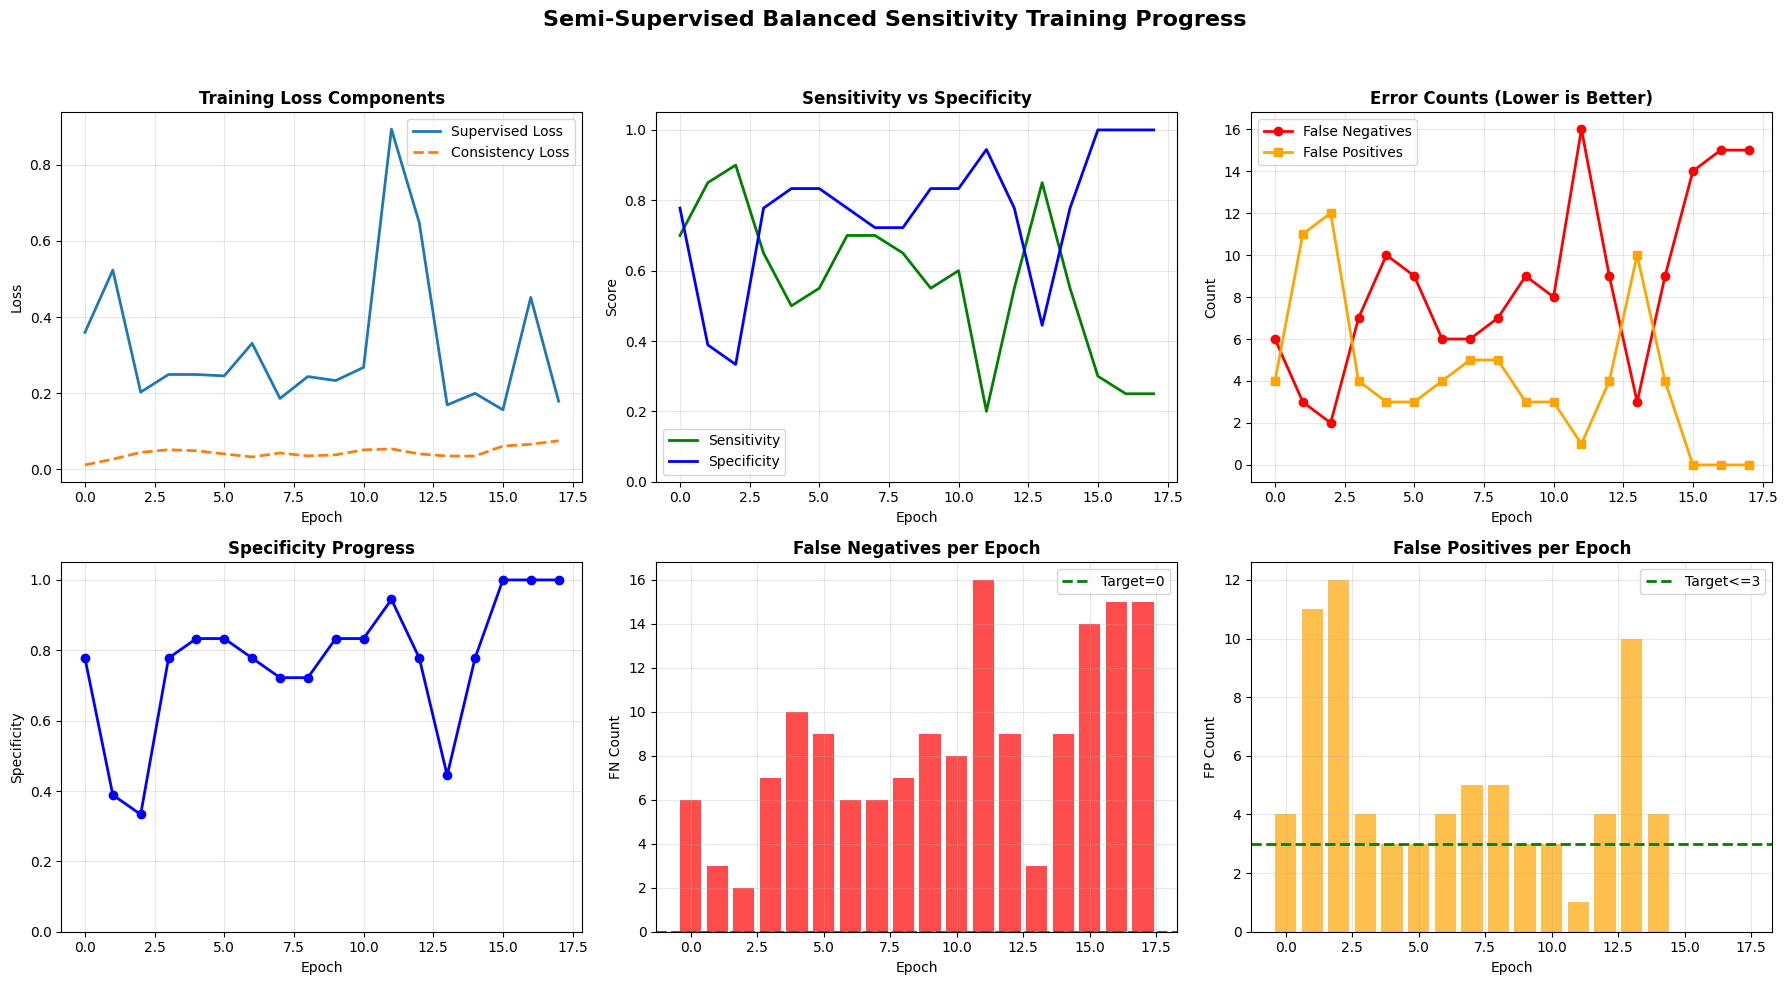


TRAINING COMPLETED SUCCESSFULLY
Model saved to: artifacts/balanced_sensitivity_model.pth
Training history saved to: artifacts/balanced_sensitivity_training_history.json
Plots saved to: artifacts/balanced_sensitivity_training_history.png

FINAL PERFORMANCE SUMMARY
Best False Negatives: 2
Best Sensitivity: 0.900
Final Specificity: 1.000


In [11]:
# ============================================================
# Execute Training
# ============================================================
if __name__ == "__main__":
    trainer, history = main()
    
    # Print final summary
    print("\n" + "="*60)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Best False Negatives: {min(history['false_negatives'])}")
    print(f"Best Sensitivity: {max(history['sensitivity']):.3f}")
    print(f"Final Specificity: {history['specificity'][-1]:.3f}")